In [58]:
using JuMP, Ipopt, DataFrames, Gadfly, Interact
set_default_plot_size(24cm, 16cm)

In [2]:
# Carregamento de dados gerados na Preparação de Dados - Cotações Bovespa
df = readtable("maxreturn.tsv")
head(df)

,CODNEG,DATE,RET
1,BRIN3,2015-11-03,0.036144578313253045
2,BRIN3,2015-11-04,-0.011363636363636374
3,BRIN3,2015-11-05,0.0
4,BRIN3,2015-11-06,-0.011363636363636374
5,BRIN3,2015-11-09,0.05882352941176476
6,BRIN3,2015-11-10,-0.01111111111111112


In [3]:
assets, R, C = readdlm("maxreturn-n.tsv"), readdlm("maxreturn-R.tsv"), readdlm("maxreturn-C.tsv")

println("Returns: mean, variance\n")
for i=1:length(assets)
    a, m, v = assets[i], round(R[i], 4), round(C[i,i], 4)
    println(a, " = (", m, ", ", v, ")")
end

Returns: mean, variance

BRIN3 = (0.0131, 0.001)
BRKM5 = (0.0088, 0.0006)
CSMG3 = (0.0109, 0.001)
ELET3 = (0.0117, 0.0016)
LOGN3 = (0.0237, 0.0167)
MAGG3 = (0.0109, 0.0006)
PNVL3 = (0.0125, 0.0006)
POSI3 = (0.0084, 0.0009)
ROMI3 = (0.0111, 0.0012)
VIVR3 = (0.0833, 0.0594)


In [59]:
n = length(assets)
R_exp = 0.01

0.01

In [8]:
model = Model(solver = IpoptSolver(print_level=0))
@defVar(model, x[1:n] ≥ 0)
@setObjective(model, Min, sum{C[i,j] * x[i] * x[j], i=1:n, j=1:n})
@addConstraint(model, sum{R[i] * x[i], i=1:n} ≥ R_exp)
@addConstraint(model, sum(x) == 1)

println("The optimization problem to be solved is:\n\n", model)

The optimization problem to be solved is:

Min 0.0010385514931687079 x[1]² - 0.0003179325790528486 x[1]*x[2] + 0.0005839162618774952 x[2]² + 3.7277605521753136e-5 x[1]*x[3] + 4.880901210256087e-5 x[2]*x[3] + 0.0010479723236304955 x[3]² + 0.00047895923694307247 x[1]*x[4] - 0.00046155253135628227 x[2]*x[4] + 0.00046422382918056215 x[3]*x[4] + 0.0015792103277959936 x[4]² + 1.6918487692688052e-5 x[1]*x[5] + 0.0010002025948380208 x[2]*x[5] - 0.0010132970548512364 x[3]*x[5] - 0.0027759609493394313 x[4]*x[5] + 0.01668813108494619 x[5]² - 0.0005162546478571059 x[1]*x[6] - 0.00024106223374948616 x[2]*x[6] + 0.0002556649448291973 x[3]*x[6] + 0.00030081842709268436 x[4]*x[6] - 3.67423411209301e-5 x[5]*x[6] + 0.0005534905103482822 x[6]² + 0.0006690495393972119 x[1]*x[7] - 0.00030344598810005957 x[2]*x[7] + 0.00029135091712061205 x[3]*x[7] + 0.0001909260053374177 x[4]*x[7] + 7.313405450067944e-5 x[5]*x[7] - 9.179414411897776e-5 x[6]*x[7] + 0.0006466307810722394 x[7]² - 0.00037894699583512846 x[1]*x

In [9]:
status = solve(model)

println("Status of the problem is ", status, "\n")

if status == :Optimal
    println("Objective value:\n\n", getObjectiveValue(model), "\n")
    println("Optimal solution:\n\n", "x = ", getValue(x))
end

Status of the problem is Optimal

Objective value:

7.282251224887068e-5

Optimal solution:

x = [0.1651789456967025,0.24679411530155956,0.005870113761601404,7.116586691696333e-5,7.390683538233849e-6,0.27815956444643575,0.1286564761505162,0.11128675544296739,0.06397546694402624,5.705735672964239e-9]


In [10]:
xopt = round(getValue(x), 2)
println("Return: ", vec(R) ⋅ xopt, "\n")
for i=1:n
    println(assets[i], " = ", xopt[i])
end

Return: 0.010803489659845912

BRIN3 = 0.17
BRKM5 = 0.25
CSMG3 = 0.01
ELET3 = 0.0
LOGN3 = 0.0
MAGG3 = 0.28
PNVL3 = 0.13
POSI3 = 0.11
ROMI3 = 0.06
VIVR3 = 0.0


In [34]:
function optret(xopt)
    r = nothing
    for i=1:n
        xopt[i] == 0.0 && continue
        q = assets[i]
        s = df[df[:CODNEG] .== q, :][:RET] * xopt[i]
        if r === nothing
            r = s
        else
            r += s
        end
    end
    DataFrame(DATE = unique(df[:DATE]), CODNEG = fill("OPT", length(r)), RET = r)
end

optdf = optret(xopt)

,DATE,CODNEG,RET
1,2015-11-03,OPT,0.01855852884997998
2,2015-11-04,OPT,0.023876370130614763
3,2015-11-05,OPT,0.02116384785817027
4,2015-11-06,OPT,0.009686817713409948
5,2015-11-09,OPT,0.012195565512095236
6,2015-11-10,OPT,0.00748110491795084
7,2015-11-11,OPT,0.024188343257014723
8,2015-11-12,OPT,-0.0063072462125665415
9,2015-11-13,OPT,0.010366644087298241
10,2015-11-16,OPT,0.0013516790240140637


In [61]:
p(df) = layer(df, x = :DATE, y = :RET, color = :CODNEG, Geom.line, Geom.point)
rplot(g) = plot(g,
    Guide.title("Retorno por dia"),
    Guide.xlabel("Data"),
    Guide.ylabel("Retorno"),
    Guide.colorkey("Ações"))

rplot (generic function with 1 method)

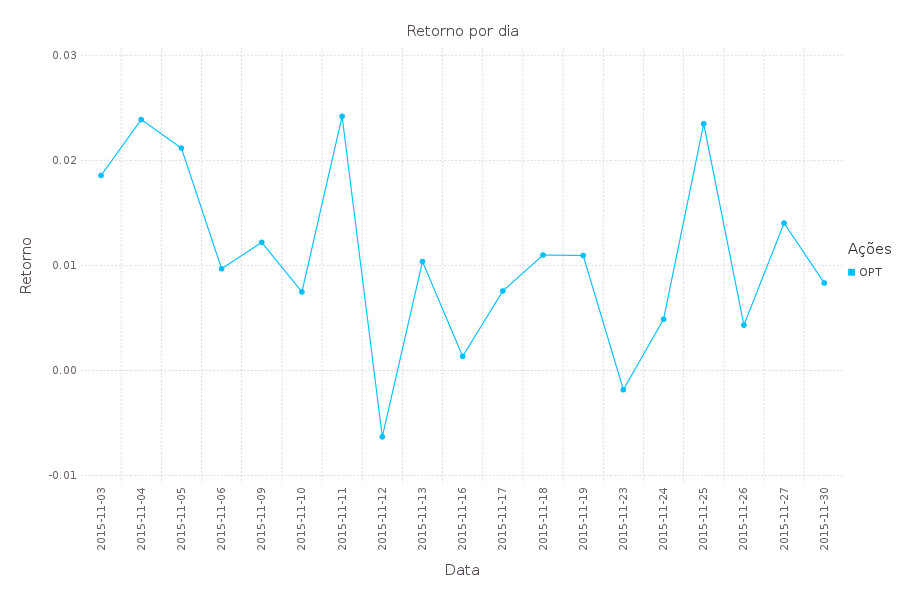

In [62]:
rplot(p(optdf))

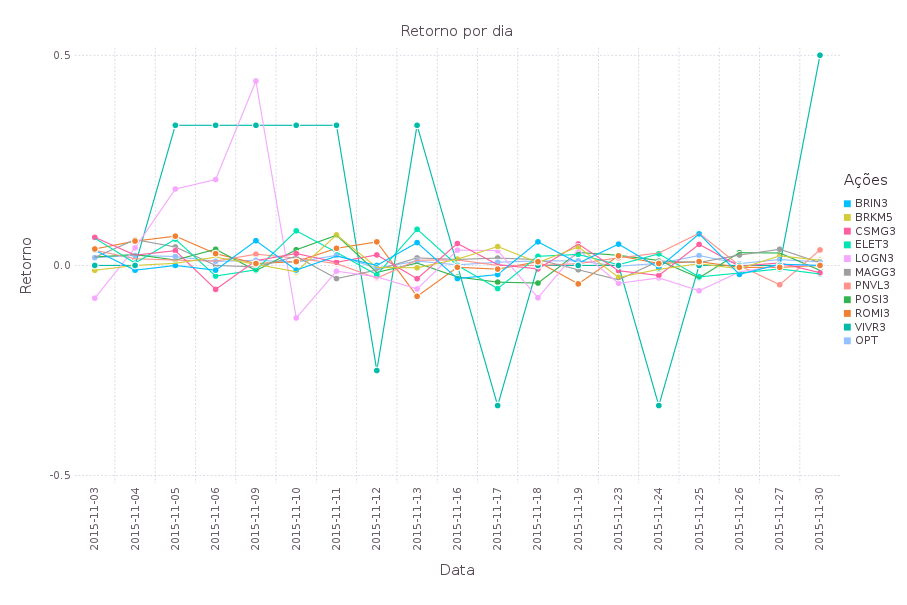

In [63]:
g = Array(Layer, 0)
for q in unique(df[:CODNEG])
    push!(g, p(df[df[:CODNEG] .== q, :])...)
end
push!(g, p(optdf)...)
rplot(g)

In [64]:
function exploreQuotes()
    @manipulate for q=unique(df[:CODNEG])
        rplot(p(df[df[:CODNEG] .== q, :]))
    end
end

exploreQuotes (generic function with 1 method)

Interact.Options{:ToggleButtons,UTF8String}([Reactive.Input{UTF8String}] BRIN3,"q","BRIN3","BRIN3",Interact.OptionDict(Any["BRIN3","BRKM5","CSMG3","ELET3","LOGN3","MAGG3","PNVL3","POSI3","ROMI3","VIVR3"],Dict{Any,Any}("PNVL3"=>"PNVL3","VIVR3"=>"VIVR3","BRIN3"=>"BRIN3","ELET3"=>"ELET3","POSI3"=>"POSI3","BRKM5"=>"BRKM5","CSMG3"=>"CSMG3","ROMI3"=>"ROMI3","MAGG3"=>"MAGG3","LOGN3"=>"LOGN3")),Any[],Any[])

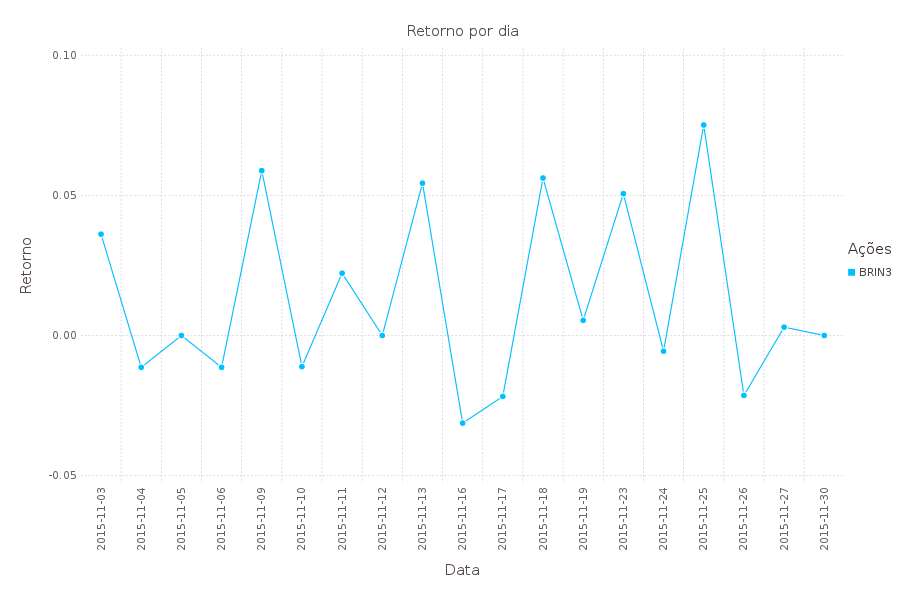

In [65]:
exploreQuotes()

In [69]:
function opt(R_exp)
    model = Model(solver = IpoptSolver(print_level=0))
    @defVar(model, x[1:n] ≥ 0)
    @setObjective(model, Min, sum{C[i,j] * x[i] * x[j], i=1:n, j=1:n})
    @addConstraint(model, sum{R[i] * x[i], i=1:n} ≥ R_exp)
    @addConstraint(model, sum(x) == 1)
    status = solve(model)
    xopt = status == :Optimal ? round(getValue(x), 2) : nothing
    status, xopt
end

opt (generic function with 1 method)

In [68]:
@manipulate for R_exp=0.0:0.005:maximum(R)
    status, xopt = opt(R_exp)
    out = string("Status of the problem is ", status, " for ", R_exp, "<br/><br/>")
    if status == :Optimal
        out = string(out, "Return: ", vec(R) ⋅ xopt, "<br/><br/>")
        for i=1:n
            out = string(out, assets[i], " = ", xopt[i], "<br/>")
        end
    end
    html(out)
end

Interact.Slider{Float64}([Reactive.Input{Float64}] 0.04,"R_exp",0.04,0.0:0.005:0.08)

Interact.HTML("","Status of the problem is Optimal for 0.04<br/><br/>Return: 0.04024732339811024<br/><br/>BRIN3 = 0.05<br/>BRKM5 = 0.0<br/>CSMG3 = 0.53<br/>ELET3 = 0.0<br/>LOGN3 = 0.02<br/>MAGG3 = 0.0<br/>PNVL3 = 0.0<br/>POSI3 = 0.0<br/>ROMI3 = 0.0<br/>VIVR3 = 0.4<br/>")

Interact.Slider{Float64}([Reactive.Input{Float64}] 0.04,"R_exp",0.04,0.0:0.005:0.08)

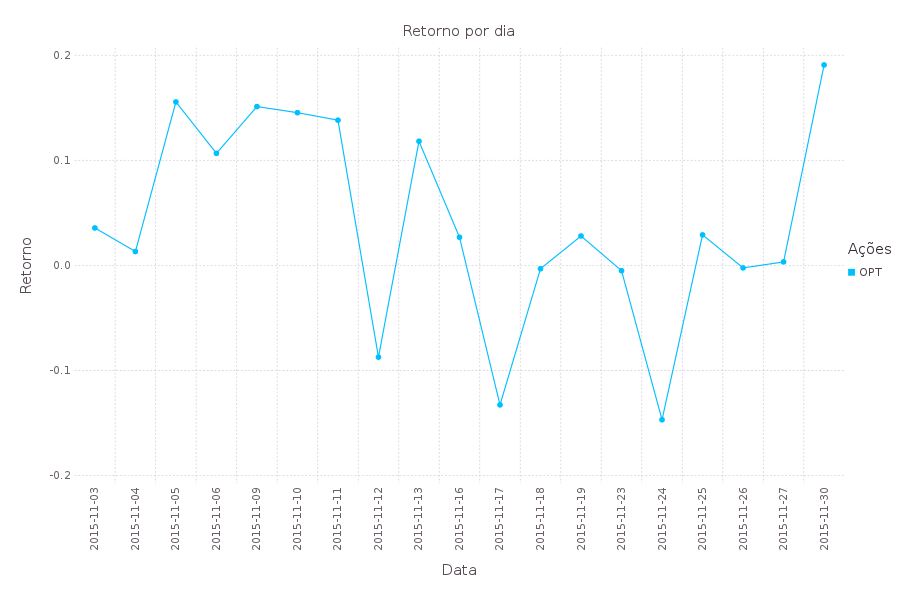

In [72]:
empty = DataFrame(DATE = AbstractString[], CODNEG = AbstractString[], RET = Float64[])
@manipulate for R_exp=0.0:0.005:maximum(R)
    status, xopt = opt(R_exp)
    optdf = status == :Optimal ? optret(xopt) : empty
    rplot(p(optdf))
end